In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
np.random.seed(42)

cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

In [25]:
# Wikipedia Stock Data
with pd.HDFStore('assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [3]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
with pd.HDFStore('assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

In [5]:
# Create month-end monthly returns and drop dates that have no observations
start = 2008
end = 2017

In [6]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WYNN    521 non-null    float64
 1   AMP     521 non-null    float64
 2   DVN     521 non-null    float64
 3   CPB     521 non-null    float64
 4   COP     521 non-null    float64
 5   L       521 non-null    float64
 6   FMC     521 non-null    float64
 7   KR      521 non-null    float64
 8   AES     521 non-null    float64
 9   NTRS    521 non-null    float64
 10  NKE     521 non-null    float64
 11  MAR     521 non-null    float64
 12  CCL     521 non-null    float64
 13  VLO     521 non-null    float64
 14  AIG     521 non-null    float64
 15  C       521 non-null    float64
 16  TEL     521 non-null    float64
 17  FE      521 non-null    float64
 18  PPL     521 non-null    float64
 19  JNJ     521 non-null    float64
 20  XOM     521 non-null    float64
 21  RSG     

In [7]:
# Set Parameters
stocks = weekly_returns.columns
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(28, 521)

In [8]:
# Number of Portfolios to Simulate
NUM_PF = 100000

In [9]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

In [10]:
# Annualization Factor
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

In [11]:
# Compute Mean Returns, Covariance and Precision Matrix
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [12]:
# Precision Matrix - Inverse of Covariance Matrix 
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [13]:
# Risk-Free Rate 

# Load historical 10-year Treasury rate
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

rf_rate = treasury_10yr_monthly.mean()

In [14]:
# Simulate Random Portfolios

# The simulation generates random weights using the Dirichlet distribution and computes the mean, standard deviation and Sharpe ratio for each sample portfolio using the historical return data

def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)
        
    returns = weights @ mean_ret.values+1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std, 'Annualized Returns': returns, 'Sharpe Ratio': sharpe}), weights

In [15]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [16]:
df = pd.DataFrame(simul_wt)
df.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,...,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000
mean,0.03553,0.03598,0.03606,0.03568,0.03526,0.03654,0.03518,0.03528,0.03495,0.03592,...,0.03587,0.03532,0.03594,0.03569,0.03528,0.03699,0.03599,0.03592,0.03589,0.03581
std,0.11933,0.11997,0.12090,0.12048,0.11793,0.12149,0.11822,0.11851,0.11777,0.12087,...,0.12003,0.11850,0.12016,0.11981,0.11907,0.12252,0.12029,0.11978,0.12058,0.12016
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00198,0.00208,0.00207,0.00183,0.00201,0.00219,0.00198,0.00199,0.00198,0.00201,...,0.00206,0.00205,0.00208,0.00193,0.00205,0.00224,0.00205,0.00200,0.00192,0.00204
max,0.99935,0.99817,0.99797,0.99985,0.99374,0.99678,0.99870,0.99801,0.99824,0.99844,...,0.99747,0.99468,0.99856,0.99604,0.99922,0.99793,0.99743,0.99739,0.99870,0.99839


Max Sharpe: 15.81%, 15.33%


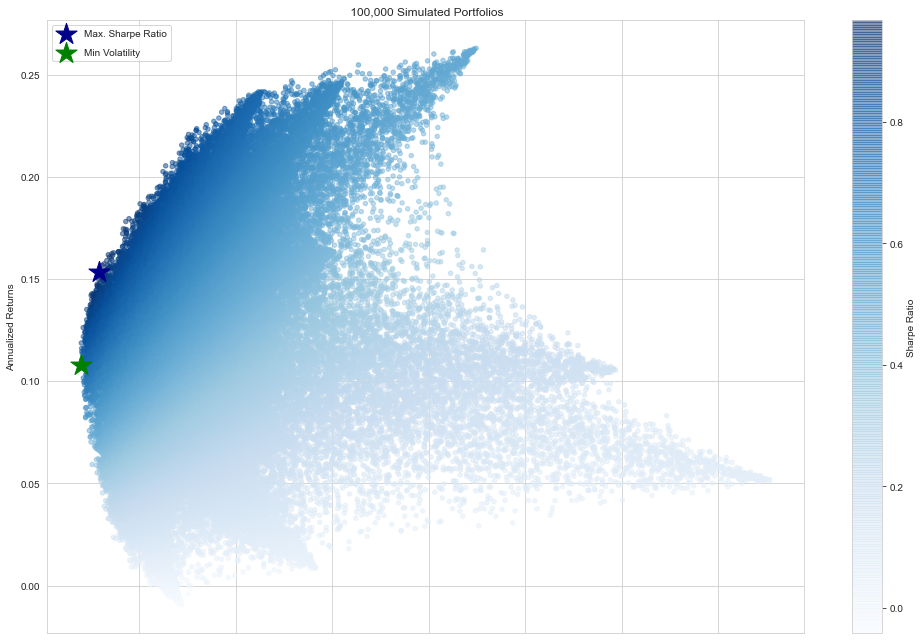

In [17]:
# Plot Simulated Portfolios 
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues', alpha=0.5, figsize=(14, 9), colorbar=True, title=f'{NUM_PF: ,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')

plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

In [18]:
# Compute Annualized PF Performance 

# Setting up quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum Sharpe Ratio

# Annualized PF standard deviation
def portfolio_std(wt, rt=None, cov=None):
    return np.sqrt(wt @ cov @ wt * periods_per_year)

# Annualized PF returns
def portfolio_returns(wt, rt=None, cov=None):
    return (wt @ rt + 1) ** periods_per_year - 1

# Annualized PF returns and standard deviation
def portfolio_performance(wt, rt, cov):
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

In [29]:
# Target function that represents the negative SR for scipy's minimize function to optimize
# The weights are bounded by [-1, 1] if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms

def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x))-1}

def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                   x0=x0,
                   args=(mean_ret, cov),
                   method='SLSQP',
                   bounds=((-1 if short else 0, 1),) * n_assets,
                   constraints=weight_constraint,
                   options={'tol': 1e-10, 'maxiter': 1e4})

In [30]:
# Compute Efficient Frontier

# Solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

def min_vol_target(mean_ret, cov, target, short=False):
    
    def ret_(wt):
        return portfolio_returns(wt, mean_ret)
    
    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target}, weight_constraint]
    
    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                   x0=x0,
                   args=(mean_ret, cov),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints,
                   options={'tol': 1e-10, 'maxiter': 1e4})

In [31]:
# Min Volatility Portfolio
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets
    
    return minimize(fun=portfolio_std,
                   x0=x0,
                   args=(mean_ret, cov),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=weight_constraint,
                   options={'tol': 1e-10, 'maxiter': 1e4})

In [32]:
# Efficient Frontier
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

In [33]:
# Calculations 

# Get Random PF
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

print(simul_perf.describe().apply(lambda x: x.apply('{0:.5f}'.format)))
print('\n')

simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
print(simul_perf.iloc[simul_max_sharpe])

# Get Max Sharpe PF
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

print('\n')
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate/sd)})

# Get Min Vol PF
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

# Get Efficient PFs
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

      Annualized Standard Deviation Annualized Returns  Sharpe Ratio
count                  100000.00000       100000.00000  100000.00000
mean                        0.27540            0.11927       0.45765
std                         0.09205            0.04851       0.19156
min                         0.13912           -0.00941      -0.04056
25%                         0.21719            0.08490       0.31273
50%                         0.25533            0.11783       0.46896
75%                         0.30294            0.15192       0.60250
max                         0.85328            0.26276       0.97330


Annualized Standard Deviation    0.169178
Annualized Returns               0.165159
Sharpe Ratio                     0.973296
Name: 67650, dtype: float64




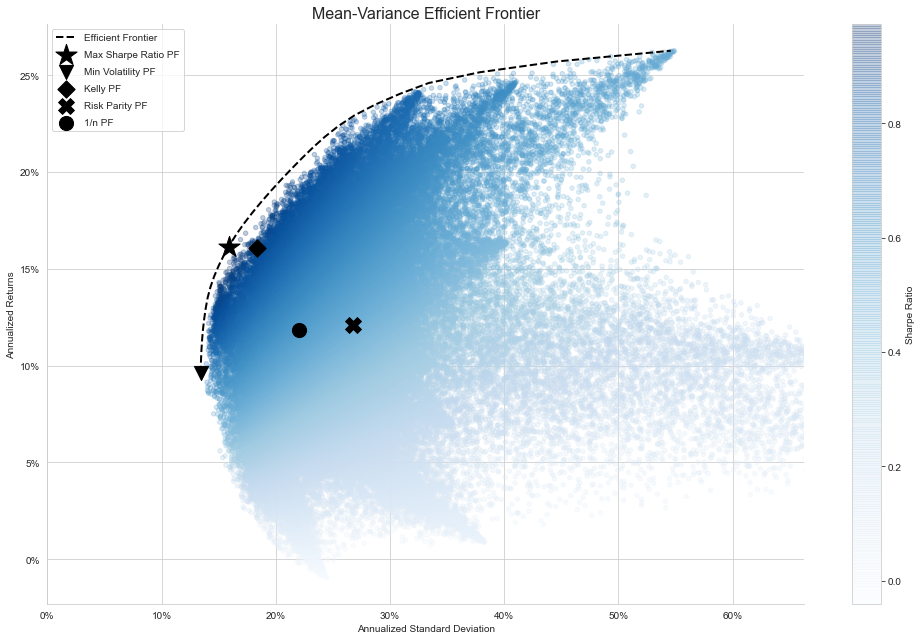

In [34]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();